In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 

In [2]:
dados_treino = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\train.csv")
dados_teste =  pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\test.csv")
feriados = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\holidays_events.csv")
preco_petroleo = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\oil.csv")
lojas = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\stores.csv")
transacoes = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\transactions.csv")


# Preparando os dados para o modelo

Quando estamos preparando modelos de aprendizado de máquina é importante ter em mente que nosso modelo será tão bom quanto os dados que fornecemos para ele. 

A qualidade, a relevância e a integridade dos dados afetam diretamente a capacidade do modelo de aprender e fazer previsões precisas. Portanto, antes de mergulhar na criação de modelos complexos, é essencial dedicar tempo e esforço à preparação adequada dos dados. 



## Adicionando a cotação do petróleo ao dataset

O conjunto dos dados representa os registros de venda de uma rede de lojas do Equador durante o período. A econômia do equador extremamente dependente do petróleo, portanto é interesante apresentar isso ao nosso modelo para que ele consiga detectar qualquer correlação na variação do preço e das vendas.

Para isso foi necessário fazer alguns tratamentos nos dados relacionados ao preço do petróleo.



In [3]:
# Criando um dataset com todas as datas em que queremos análisar as vendas 

total_datas = np.concatenate((dados_treino['date'].unique(),dados_teste['date'].unique()))
nanobj = np.array([np.nan for d in total_datas])
dicio = {'date': total_datas,
        'preco': nanobj }
preco_petroleo_todos = pd.DataFrame(data=dicio)

#Adicionando a cotação do petroleo para todas as datas disponíveis 

for i in preco_petroleo.itertuples():
   for j in preco_petroleo_todos.itertuples():
        if i.date == j.date:
            preco_petroleo_todos.at[j.Index,'preco'] = i.dcoilwtico
            break

#Tratando dias em que a cotação do petroleo não foi registrada.
#um dia com a cotação de petróleo não registrada recebe o valor do próximo dia em que a cotação foi registrada
#Essa forma de tratamento é interessante pois preserva o comportamento do preço durante a série temporal

for i in preco_petroleo_todos.itertuples():
    if np.isnan(i.preco) == True:
        for j in preco_petroleo_todos[i.Index+1:].itertuples():
            if np.isnan(j.preco) == False:
                preco_petroleo_todos.at[i.Index,'preco'] = j.preco
                break
 

<Axes: xlabel='date', ylabel='preco'>

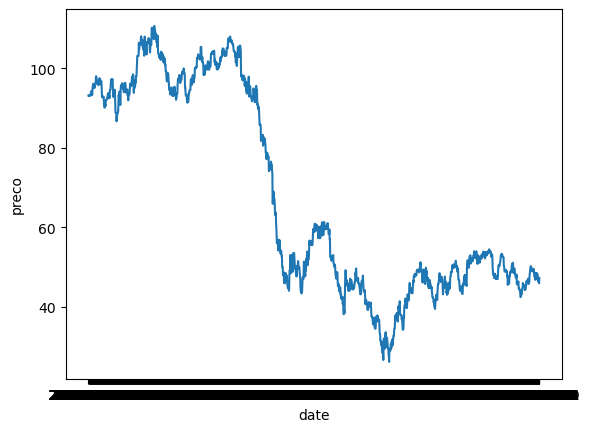

In [4]:
 sns.lineplot(data = preco_petroleo_todos, x= 'date', y = 'preco')

In [5]:
#Criando dicionário com cotação diária e criando colunas nos datasets de teste e treino

dicio_petroleo = {}
for i in preco_petroleo_todos.itertuples():
    dicio_petroleo[i.date] = i.preco

petroleo_treino = []
for i in dados_treino.itertuples():
    petroleo_treino.append(dicio_petroleo[i.date])
    
petroleo_teste = []
for i in dados_teste.itertuples():
    petroleo_teste.append(dicio_petroleo[i.date])
    
complete_data_treino = dados_treino
complete_data_treino['Petroleo'] = petroleo_treino

complete_data_teste = dados_teste
complete_data_teste['Petroleo'] = petroleo_teste


## Adicionando metadados das lojas 

In [6]:
complete_data_treino = pd.merge(complete_data_treino,lojas,how='inner',on = 'store_nbr')
complete_data_teste = pd.merge(complete_data_teste,lojas,how='inner',on = 'store_nbr')

# Organizando a sequência das séries

In [7]:
serie_organized_data = pd.DataFrame(columns = complete_data_treino.columns.values )

In [8]:


for str in complete_data_treino['store_nbr'].unique():
    for f in complete_data_treino['family'].unique():
        train_serie1 = complete_data_treino.loc[(complete_data_treino['store_nbr']== str) & (complete_data_treino['family']== f)]
        break
    break



In [9]:
for str in complete_data_teste['store_nbr'].unique():
    for f in complete_data_teste['family'].unique():
        keagle_target = complete_data_teste.loc[(complete_data_teste['store_nbr']== str) & (complete_data_teste['family']== f)]
        break
    break


## Apenas Uma serie univariada 

In [10]:
train_serie1.head()

,id,date,store_nbr,family,sales,onpromotion,Petroleo,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,Quito,Pichincha,D,13
66,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,92.97,Quito,Pichincha,D,13
99,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,93.12,Quito,Pichincha,D,13
132,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,93.20,Quito,Pichincha,D,13


In [12]:
train_serie1['date'] = pd.to_datetime(train_serie1['date'] )
train_serie1 = train_serie1.set_index('date')
petrol = train_serie1['Petroleo']

KeyError: 'date'

In [15]:
train_serie1['Petroleo'].head()

date
2013-01-01    93.14
2013-01-02    93.14
2013-01-03    92.97
2013-01-04    93.12
2013-01-05    93.20
Name: Petroleo, dtype: float64

### Darts time series

In [16]:
from darts import TimeSeries
train_serie = TimeSeries.from_dataframe(df=train_serie1,
                                        value_cols='sales',
                                       fill_missing_dates=True,
                                       static_covariates=train_serie1['Petroleo'])

In [17]:
print(train_serie.static_covariates)

static_covariates  2013-01-01  2013-01-02  2013-01-03  2013-01-04  2013-01-05  \
component                                                                       
sales                   93.14       93.14       92.97       93.12        93.2   

static_covariates  2013-01-06  2013-01-07  2013-01-08  2013-01-09  2013-01-10  \
component                                                                       
sales                    93.2        93.2       93.21       93.08       93.81   

static_covariates  ...  2017-08-06  2017-08-07  2017-08-08  2017-08-09  \
component          ...                                                   
sales              ...       49.37       49.37       49.07       49.59   

static_covariates  2017-08-10  2017-08-11  2017-08-12  2017-08-13  2017-08-14  \
component                                                                       
sales                   48.54       48.81       47.59       47.59       47.59   

static_covariates  2017-08-15  
component    

### Train test Split

Normalizando static covariant

In [18]:
from darts.dataprocessing.transformers import StaticCovariatesTransformer

Scalar = StaticCovariatesTransformer()
transformada = Scalar.fit_transform(train_serie)

In [20]:
print(transformada.static_covariates)

static_covariates  2013-01-01  2013-01-02  2013-01-03  2013-01-04  2013-01-05  \
component                                                                       
sales                     0.0         0.0         0.0         0.0         0.0   

static_covariates  2013-01-06  2013-01-07  2013-01-08  2013-01-09  2013-01-10  \
component                                                                       
sales                     0.0         0.0         0.0         0.0         0.0   

static_covariates  ...  2017-08-06  2017-08-07  2017-08-08  2017-08-09  \
component          ...                                                   
sales              ...         0.0         0.0         0.0         0.0   

static_covariates  2017-08-10  2017-08-11  2017-08-12  2017-08-13  2017-08-14  \
component                                                                       
sales                     0.0         0.0         0.0         0.0         0.0   

static_covariates  2017-08-15  
component    

In [ ]:

sns.set_palette('Accent')
sns.set_style('darkgrid')
ax = sns.lineplot(data=train_Data_Sales,x='date',y='sales')
ax.figure.set_size_inches(12,6)